Fetch information about a specific person identified by his/her ORCID ID, and handle API errors.

[Download Notebook](https://github.com/researchgraph/augment-api-beta/blob/main/docs/notebooks/orcid.ipynb)

In [28]:
import sys
sys.path.append('../')

# !{sys.executable} -m pip install matplotlib

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import ast
import altair as alt
import networkx as nx
import nx_altair as nxa
from wordcloud import WordCloud, STOPWORDS 
import pandas as pd
from datetime import datetime, date
import requests
import json

import os
from os.path import join, dirname
from dotenv import load_dotenv
load_dotenv();

### ORCID ID not found

In [29]:
# ORCID ID not found
API_KEY = os.environ.get("API_KEY")
ORCID = "0000-0003-XXXX-XXXX"

url = f'https://f130.azure-api.net/v1/orcid/{ORCID}?subscription-key={API_KEY}'
r = requests.get(url)

# print a short confirmation on completion
print('Augment API query complete ', r.status_code)

if r.status_code == 400:
    print(r.json()["message"])

Augment API query complete  400
FAILED: Invalid ORCID 0000-0003-XXXX-XXXX


### Missing API_KEY

In [30]:
# Missing API_KEY
API_KEY = ''
ORCID = "0000-0002-0068-716X"

url = f'https://f130.azure-api.net/v1/orcid/{ORCID}?subscription-key={API_KEY}'
r = requests.get(url)

# print a short confirmation on completion
print('Augment API query complete ', r.status_code)

if r.status_code == 401:
    print(f'Authentication error.')

Augment API query complete  401
Authentication error.


### ORCID ID does exist

In [31]:
# ORCID ID does exist
API_KEY = os.environ.get("API_KEY")
ORCID = "0000-0002-0068-716X"

url = f'https://f130.azure-api.net/v1/orcid/{ORCID}?subscription-key={API_KEY}'
r = requests.get(url)

# print a short confirmation on completion
print('Augment API query complete ', r.status_code)

if r.status_code == 200 and r.json()[0]["nodes"]["researchers"]:    
    researchers = r.json()[0]["nodes"]["researchers"]
    
    researcher = None
    for i in range(len(researchers)):
        if researchers[i]["orcid"] == ORCID:
            researcher = researchers[i]

print()
print(f'ORCID: {researcher["orcid"]}')
print(f'First name: {researcher["first_name"]}')
print(f'Last name: {researcher["last_name"]}')
print()
print(f'The researcher {researcher["full_name"]} is connected to {r.json()[0]["stats"]}.')

Augment API query complete  200

ORCID: 0000-0002-0068-716X
First name: Cameron
Last name: Neylon

The researcher Cameron Neylon is connected to {'datasets': 0, 'grants': 0, 'organisations': 207, 'publications': 157, 'researchers': 126}.


### List of co-authors
Only includes co-authors with ORCID IDs.

In [32]:
rf = pd.DataFrame(r.json()[0]["nodes"]["researchers"], columns=['first_name', 'last_name', 'full_name', 'orcid'])
dfStyler = rf.style.set_properties(**{'text-align': 'left'})
dfStyler.set_table_styles([dict(selector='th', props=[('text-align', 'left')])])

,first_name,last_name,full_name,orcid
0,Patricia,Cruse,Patricia Cruse,0000-0002-9300-5278
1,John,Chodacki,John Chodacki,0000-0002-7378-2408
2,Anthony,Caravaggi,Anthony Caravaggi,0000-0002-1763-8970
3,Alkim,Ozaygen,Alkim Ozaygen,0000-0001-6813-8362
4,Susana,Teixeira,Susana Teixeira,0000-0002-6603-7936
5,Gabriel,Cavalli,Gabriel Cavalli,0000-0002-2856-1956
6,Judith,Peters,Judith Peters,0000-0001-5151-7710
7,Damian,Pattinson,Damian Pattinson,0000-0002-2606-6599
8,Julien,Colomb,Julien Colomb,0000-0002-3127-5520
9,Matthew,Blakeley,Matthew Blakeley,0000-0002-6412-4358


In [33]:
# Fetch relationships between all co-authors
API_KEY = os.environ.get("API_KEY")

# Generate a graph from the co-authors
G = nx.Graph()

for a in rf['orcid']:
    url = f'https://f130.azure-api.net/v1/orcid/{a}?subscription-key={API_KEY}'
    r = requests.get(url)

    # print a short confirmation on completion
    print('Augment API query complete ', r.status_code)
    
    json = map(force_orcid, r.json()[0]['relationships']['researcher-researcher'])
    ef = pd.DataFrame(json, columns=['from', 'to'])
    ef = ef[ef['to'].isin(rf['orcid'].to_list())]
    G.add_edges_from(ef.to_numpy())

Augment API query complete  200
Augment API query complete  200
Augment API query complete  200
Augment API query complete  200
Augment API query complete  200
Augment API query complete  200
Augment API query complete  200
Augment API query complete  200
Augment API query complete  200
Augment API query complete  200
Augment API query complete  200
Augment API query complete  200
Augment API query complete  200
Augment API query complete  200
Augment API query complete  200
Augment API query complete  200
Augment API query complete  200
Augment API query complete  200
Augment API query complete  200
Augment API query complete  200
Augment API query complete  200
Augment API query complete  200
Augment API query complete  200
Augment API query complete  200
Augment API query complete  200
Augment API query complete  200
Augment API query complete  200
Augment API query complete  200
Augment API query complete  200
Augment API query complete  200
Augment API query complete  200
Augment 

Graph with 163 nodes and 809 edges
Network density: 0.06127395288949481


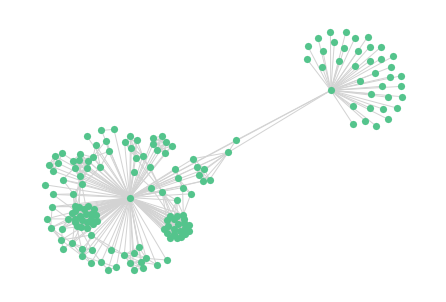

In [48]:
for index, row in rf.iterrows():
    G.add_node(row['orcid'], name=row['full_name'], color='#54C48C')

# Convert from and to into ORCID IDs (to map the node labels)
def force_orcid(n):
    n['from'] = n['from'].split('/')[-1]
    n['to'] = n['to'].split('/')[-1]
    return n

json = map(force_orcid, r.json()[0]['relationships']['researcher-researcher'])
ef = pd.DataFrame(json, columns=['from', 'to'])
G.add_edges_from(ef.to_numpy())

# Compute positions
pos = nx.spring_layout(G)

options = {
    "font_size": 12,
    "node_size": 50,
    "edge_color": "lightgray",
    "node_color": "#54C48C",
    "linewidths": 0.1,
    "width": 1
}

# Show information about the graph
print(nx.info(G))
print("Network density:", nx.density(G))

# export graph to a gephi file
nx.write_gexf(G, "co-authors.gexf")

# Draw the graph using matplotlib
nx.draw(G, pos=pos, **options)